In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, learning_curve, StratifiedKFold
from sklearn.metrics import *
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn import tree
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score
from sklearn.feature_selection import RFECV
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

import pickle

from hyperopt import fmin, tpe, hp, STATUS_OK, Trials, space_eval
from hyperopt.pyll import scope

import mlflow
from pyngrok import ngrok

import shap
import lime
from lime import lime_tabular

from IPython.display import Image

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [2]:
titanic_train = pd.read_csv('titanic_train_nettoyer.csv')
titanic_test = pd.read_csv('titanic_test_nettoyer.csv')

In [3]:
#Fit scaler to our training data
scaler = StandardScaler()
scaler.fit(titanic_train)
scaled_train = scaler.transform(titanic_train)

In [4]:
#Fit scaler to our test data
scaler = StandardScaler()
scaler.fit(titanic_test)
scaled_test = scaler.transform(titanic_test)

In [5]:
#In order to keep our column names we include scaled_values to our train/test dataframes like this
df_train = pd.DataFrame(scaled_train, index=titanic_train.index, columns=titanic_train.columns)
df_test = pd.DataFrame(scaled_test, index=titanic_test.index, columns=titanic_test.columns)

In [6]:
df_train.head()

,Unnamed: 0,Age,Fare,Parch,PassengerId,SibSp,Survived,Family_Size,Is_Married,Pclass_1,Pclass_2,Pclass_3,Sex_1,Sex_2,Embarked_1,Embarked_2,Embarked_3,Title_1,Title_2,Title_3,Title_4,Family_Size_Grouped_1,Family_Size_Grouped_2,Family_Size_Grouped_3,Family_Size_Grouped_4
0,-1.730108,-0.453298,-1.556514,-0.473674,-1.730108,0.432793,-0.789272,0.059160,-0.403962,-0.565685,-0.510152,0.902587,-0.737695,0.737695,-0.482043,-0.307562,0.615838,-0.155364,-0.216803,-0.735882,0.850532,-1.231645,-0.169907,-0.208148,1.432260
1,-1.726220,0.668615,1.348169,-0.473674,-1.726220,0.432793,1.266990,0.059160,2.475480,1.767767,-0.510152,-1.107926,1.355574,-1.355574,2.074505,-0.307562,-1.623803,-0.155364,-0.216803,1.358913,-1.175735,-1.231645,-0.169907,-0.208148,1.432260
2,-1.722332,-0.079327,-0.764328,-0.473674,-1.722332,-0.474545,1.266990,-0.560975,-0.403962,-0.565685,-0.510152,0.902587,1.355574,-1.355574,-0.482043,-0.307562,0.615838,-0.155364,-0.216803,1.358913,-1.175735,0.811922,-0.169907,-0.208148,-0.698197
3,-1.718444,0.294644,1.084107,-0.473674,-1.718444,0.432793,1.266990,0.059160,2.475480,1.767767,-0.510152,-1.107926,1.355574,-1.355574,-0.482043,-0.307562,0.615838,-0.155364,-0.216803,1.358913,-1.175735,-1.231645,-0.169907,-0.208148,1.432260
4,-1.714556,0.294644,-0.764328,-0.473674,-1.714556,-0.474545,-0.789272,-0.560975,-0.403962,-0.565685,-0.510152,0.902587,-0.737695,0.737695,-0.482043,-0.307562,0.615838,-0.155364,-0.216803,-0.735882,0.850532,0.811922,-0.169907,-0.208148,-0.698197


In [7]:
df_test.head()

,Unnamed: 0,Age,Fare,Parch,PassengerId,SibSp,Family_Size,Is_Married,Pclass_1,Pclass_2,Pclass_3,Sex_1,Sex_2,Embarked_1,Embarked_2,Embarked_3,Title_1,Title_2,Title_3,Title_4,Family_Size_Grouped_1,Family_Size_Grouped_2,Family_Size_Grouped_3,Family_Size_Grouped_4
0,-1.727912,0.290418,-1.014192,-0.400248,-1.727912,-0.499470,-0.553443,-0.456172,-0.586559,-0.534933,0.957826,-0.755929,0.755929,-0.568142,2.843757,-1.350676,-0.11003,-0.229993,-0.755929,0.861201,0.807573,-0.156556,-0.156556,-0.728790
1,-1.719625,1.457676,-1.535955,-0.400248,-1.719625,0.616992,0.105643,2.192158,-0.586559,-0.534933,0.957826,1.322876,-1.322876,-0.568142,-0.351647,0.740370,-0.11003,-0.229993,1.322876,-1.161169,-1.238278,-0.156556,-0.156556,1.372137
2,-1.711337,2.624934,-0.492429,-0.400248,-1.711337,-0.499470,-0.553443,-0.456172,-0.586559,1.869391,-1.044031,-0.755929,0.755929,-0.568142,2.843757,-1.350676,-0.11003,-0.229993,-0.755929,0.861201,0.807573,-0.156556,-0.156556,-0.728790
3,-1.703050,-0.098668,-0.492429,-0.400248,-1.703050,-0.499470,-0.553443,-0.456172,-0.586559,-0.534933,0.957826,-0.755929,0.755929,-0.568142,-0.351647,0.740370,-0.11003,-0.229993,-0.755929,0.861201,0.807573,-0.156556,-0.156556,-0.728790
4,-1.694763,-0.487754,-0.231548,0.619896,-1.694763,0.616992,0.764728,2.192158,-0.586559,-0.534933,0.957826,1.322876,-1.322876,-0.568142,-0.351647,0.740370,-0.11003,-0.229993,1.322876,-1.161169,-1.238278,-0.156556,-0.156556,1.372137


In [8]:
target = titanic_train['Survived']
target.head()

0    0.0
1    1.0
2    1.0
3    1.0
4    0.0
Name: Survived, dtype: float64

In [9]:
drop_col = ['Unnamed: 0','PassengerId']
df_train.drop(columns=drop_col,inplace=True)
df_test.drop(columns=drop_col,inplace=True)

In [10]:
df_train.drop(columns = ['Survived'],inplace=True)

In [11]:
X_train, X_test, y_train, y_test = train_test_split(df_train, target, test_size=0.2, random_state=42)

In [12]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape  

((712, 22), (179, 22), (712,), (179,))

In [13]:
y_train.value_counts()

0.0    444
1.0    268
Name: Survived, dtype: int64

In [14]:
lr = LogisticRegression(random_state=42)

gnb = GaussianNB()

dtc = tree.DecisionTreeClassifier(random_state=42)

rfc = RandomForestClassifier(random_state=42)

cbc = CatBoostClassifier(random_state=42)

lgbmc = LGBMClassifier(random_state=42)

xgbc = XGBClassifier(random_state=42)

In [15]:
models = [lr, gnb, dtc, rfc, cbc, lgbmc, xgbc]

In [16]:
def train_models(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    metrics = {
      'AUC': round(roc_auc_score(y_test, model.predict_proba(X_test)[:,1]),2),
      'Accuracy': round(accuracy_score(y_test, model.predict(X_test)),2),
      'Precision': round(precision_score(y_test, model.predict(X_test)),2),
      'Recall': round(recall_score(y_test, model.predict(X_test)),2),
      'F1': round(f1_score(y_test, model.predict(X_test)),2)
    }
    return metrics

In [17]:
%%time

name = []
auc = []
accuracy = []
precision = []
recall = []
f1 = []
time_ = []

for model in models:
    start = time.time()
    results = train_models(model, X_train, X_test, y_train, y_test)

    name.append(type(model).__name__)
    auc.append(results['AUC'])
    accuracy.append(results['Accuracy'])
    precision.append(results['Precision'])
    recall.append(results['Recall'])
    f1.append(results['F1'])
    time_.append(time.time()-start)

#Initialise data of lists
base_models = pd.DataFrame(data=[name, auc, accuracy, precision, recall, f1, time_]).T
base_models.columns = ['Model', 'AUC', 'Accuracy', 'Precision', 'Recall', 'F1', 'Time']

Learning rate set to 0.008911
0:	learn: 0.6868225	total: 136ms	remaining: 2m 16s
1:	learn: 0.6805855	total: 138ms	remaining: 1m 9s
2:	learn: 0.6759113	total: 140ms	remaining: 46.6s
3:	learn: 0.6700028	total: 142ms	remaining: 35.4s
4:	learn: 0.6646533	total: 144ms	remaining: 28.6s
5:	learn: 0.6591121	total: 146ms	remaining: 24.2s
6:	learn: 0.6549458	total: 148ms	remaining: 21s
7:	learn: 0.6496003	total: 151ms	remaining: 18.8s
8:	learn: 0.6440660	total: 153ms	remaining: 16.9s
9:	learn: 0.6392970	total: 155ms	remaining: 15.4s
10:	learn: 0.6352022	total: 157ms	remaining: 14.1s
11:	learn: 0.6304826	total: 159ms	remaining: 13.1s
12:	learn: 0.6258126	total: 161ms	remaining: 12.2s
13:	learn: 0.6217071	total: 163ms	remaining: 11.4s
14:	learn: 0.6173245	total: 165ms	remaining: 10.9s
15:	learn: 0.6129353	total: 168ms	remaining: 10.3s
16:	learn: 0.6090644	total: 170ms	remaining: 9.82s
17:	learn: 0.6051938	total: 172ms	remaining: 9.36s
18:	learn: 0.6012848	total: 174ms	remaining: 8.96s
19:	learn: 0

283:	learn: 0.3629996	total: 595ms	remaining: 1.5s
284:	learn: 0.3628790	total: 597ms	remaining: 1.5s
285:	learn: 0.3626215	total: 599ms	remaining: 1.49s
286:	learn: 0.3625325	total: 600ms	remaining: 1.49s
287:	learn: 0.3623715	total: 602ms	remaining: 1.49s
288:	learn: 0.3620806	total: 603ms	remaining: 1.48s
289:	learn: 0.3619101	total: 605ms	remaining: 1.48s
290:	learn: 0.3616711	total: 607ms	remaining: 1.48s
291:	learn: 0.3615345	total: 609ms	remaining: 1.48s
292:	learn: 0.3610714	total: 610ms	remaining: 1.47s
293:	learn: 0.3608231	total: 612ms	remaining: 1.47s
294:	learn: 0.3605948	total: 613ms	remaining: 1.47s
295:	learn: 0.3604771	total: 615ms	remaining: 1.46s
296:	learn: 0.3602535	total: 617ms	remaining: 1.46s
297:	learn: 0.3600987	total: 618ms	remaining: 1.46s
298:	learn: 0.3600019	total: 620ms	remaining: 1.45s
299:	learn: 0.3599089	total: 622ms	remaining: 1.45s
300:	learn: 0.3596892	total: 623ms	remaining: 1.45s
301:	learn: 0.3595593	total: 625ms	remaining: 1.44s
302:	learn: 0.

515:	learn: 0.3322834	total: 984ms	remaining: 923ms
516:	learn: 0.3322480	total: 986ms	remaining: 921ms
517:	learn: 0.3321466	total: 987ms	remaining: 919ms
518:	learn: 0.3320866	total: 989ms	remaining: 916ms
519:	learn: 0.3318661	total: 990ms	remaining: 914ms
520:	learn: 0.3318023	total: 992ms	remaining: 912ms
521:	learn: 0.3317467	total: 993ms	remaining: 909ms
522:	learn: 0.3315771	total: 995ms	remaining: 907ms
523:	learn: 0.3314772	total: 996ms	remaining: 905ms
524:	learn: 0.3312455	total: 998ms	remaining: 903ms
525:	learn: 0.3311516	total: 1000ms	remaining: 901ms
526:	learn: 0.3309297	total: 1s	remaining: 899ms
527:	learn: 0.3307862	total: 1s	remaining: 897ms
528:	learn: 0.3307487	total: 1s	remaining: 894ms
529:	learn: 0.3306996	total: 1.01s	remaining: 893ms
530:	learn: 0.3305942	total: 1.01s	remaining: 890ms
531:	learn: 0.3305937	total: 1.01s	remaining: 888ms
532:	learn: 0.3305656	total: 1.01s	remaining: 885ms
533:	learn: 0.3304424	total: 1.01s	remaining: 883ms
534:	learn: 0.330212

742:	learn: 0.3077024	total: 1.37s	remaining: 473ms
743:	learn: 0.3076073	total: 1.37s	remaining: 472ms
744:	learn: 0.3074877	total: 1.37s	remaining: 470ms
745:	learn: 0.3074775	total: 1.37s	remaining: 468ms
746:	learn: 0.3074201	total: 1.37s	remaining: 466ms
747:	learn: 0.3073296	total: 1.38s	remaining: 464ms
748:	learn: 0.3072762	total: 1.38s	remaining: 462ms
749:	learn: 0.3072108	total: 1.38s	remaining: 460ms
750:	learn: 0.3071286	total: 1.38s	remaining: 458ms
751:	learn: 0.3070114	total: 1.38s	remaining: 456ms
752:	learn: 0.3068869	total: 1.38s	remaining: 454ms
753:	learn: 0.3068671	total: 1.39s	remaining: 452ms
754:	learn: 0.3067995	total: 1.39s	remaining: 450ms
755:	learn: 0.3067068	total: 1.39s	remaining: 448ms
756:	learn: 0.3065129	total: 1.39s	remaining: 446ms
757:	learn: 0.3064435	total: 1.39s	remaining: 445ms
758:	learn: 0.3064065	total: 1.39s	remaining: 443ms
759:	learn: 0.3063544	total: 1.4s	remaining: 441ms
760:	learn: 0.3062863	total: 1.4s	remaining: 439ms
761:	learn: 0.

992:	learn: 0.2822228	total: 1.76s	remaining: 12.4ms
993:	learn: 0.2821557	total: 1.76s	remaining: 10.6ms
994:	learn: 0.2820888	total: 1.76s	remaining: 8.86ms
995:	learn: 0.2820654	total: 1.76s	remaining: 7.08ms
996:	learn: 0.2820057	total: 1.76s	remaining: 5.31ms
997:	learn: 0.2819070	total: 1.77s	remaining: 3.54ms
998:	learn: 0.2818213	total: 1.77s	remaining: 1.77ms
999:	learn: 0.2816968	total: 1.77s	remaining: 0us
CPU times: total: 6.75 s
Wall time: 2.86 s


In [18]:
base_models

,Model,AUC,Accuracy,Precision,Recall,F1,Time
0,LogisticRegression,0.9,0.84,0.81,0.8,0.8,0.029891
1,GaussianNB,0.85,0.79,0.75,0.74,0.75,0.017951
2,DecisionTreeClassifier,0.8,0.81,0.79,0.73,0.76,0.016955
3,RandomForestClassifier,0.89,0.82,0.78,0.77,0.78,0.313162
4,CatBoostClassifier,0.92,0.82,0.8,0.74,0.77,1.935316
5,LGBMClassifier,0.91,0.84,0.81,0.8,0.8,0.061835
6,XGBClassifier,0.89,0.83,0.81,0.77,0.79,0.478983


In [19]:
params = {
    'solver' : ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
    'penalty' :  ['none', 'l1', 'l2', 'elasticnet'],
    'C' : [100, 10, 1.0, 0.1, 0.01]
}

In [20]:
%%time
grid = GridSearchCV(lr, param_grid=params, cv=5)
grid.fit(X_train, y_train)

CPU times: total: 12.5 s
Wall time: 4.2 s


GridSearchCV(cv=5, estimator=LogisticRegression(random_state=42),
             param_grid={'C': [100, 10, 1.0, 0.1, 0.01],
                         'penalty': ['none', 'l1', 'l2', 'elasticnet'],
                         'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag',
                                    'saga']})

In [21]:
best_model = grid.best_estimator_

In [22]:
y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:,1]

In [23]:
print('AUC : '+ str(roc_auc_score(y_test, y_proba)))
print('Accuracy : '+ str(accuracy_score(y_test, y_pred)))
print('Precision : '+ str(precision_score(y_test, y_pred)))
print('Recall : '+ str(recall_score(y_test, y_pred)))
print('F1 : '+ str(f1_score(y_test, y_pred)))

AUC : 0.8956885456885456
Accuracy : 0.8379888268156425
Precision : 0.8082191780821918
Recall : 0.7972972972972973
F1 : 0.802721088435374


In [24]:
best_params = grid.best_params_
print("Best params : " , best_params)

Best params :  {'C': 1.0, 'penalty': 'l2', 'solver': 'newton-cg'}


In [25]:
%%time
best_model = train_models(LogisticRegression(**best_params,random_state=42), X_train, X_test, y_train, y_test)
best_model

CPU times: total: 46.9 ms
Wall time: 40 ms


{'AUC': 0.9, 'Accuracy': 0.84, 'Precision': 0.81, 'Recall': 0.8, 'F1': 0.8}

In [28]:
mlflow.set_experiment("Titanic")
mlflow.sklearn.autolog()
with mlflow.start_run(run_name='LogisticRegression best params') as run:
        estimator = LogisticRegression(**best_params,random_state=42)
        estimator.fit(X_train, y_train)


2023/05/25 10:33:20 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of sklearn. If you encounter errors during autologging, try upgrading / downgrading sklearn to a supported version, or try upgrading MLflow.


2023/05/25 10:33:34 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '2e8f982d8dad4b23bb4f02f6462eac90', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow


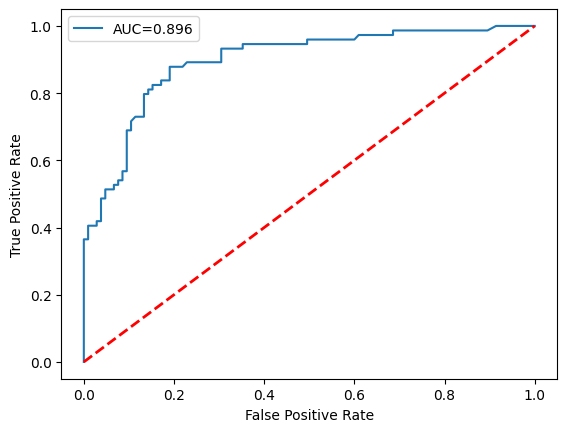

In [29]:
lr.fit(X_train,y_train)

fpr,tpr,_ = roc_curve(y_test, lr.predict_proba(X_test)[:,1])

roc_auc = roc_auc_score(y_test, lr.predict_proba(X_test)[:,1])

plt.plot(fpr,tpr,label="AUC="+str(round(roc_auc,3)))
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend()
plt.show()

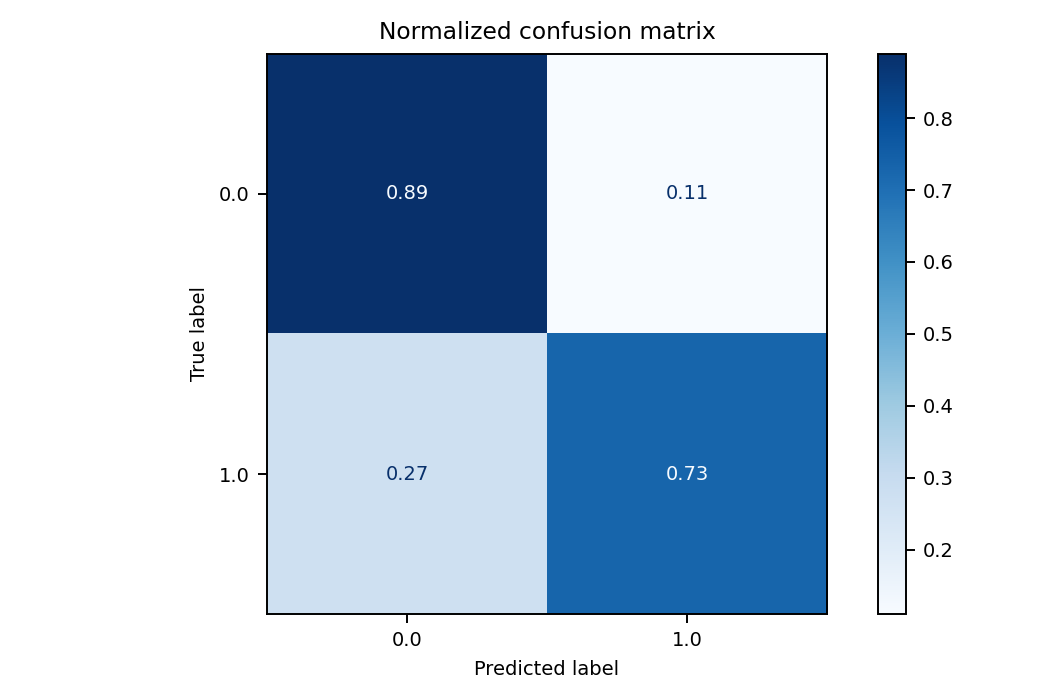

In [30]:
Image(filename='D:/pierr/Documents/images/titanic_confusion_matrix.png',width=800,height=600)

In [26]:
#terminate open tunnels if exist
ngrok.kill()

#setting authtoken
NGROK_AUTH_TOKEN = '2MdJQSFyXoyfsTaQ13hl8y5J75k_4JmdNafGinU44oYyifsq7'
ngrok.set_auth_token(NGROK_AUTH_TOKEN)

#open https tunnel on port 5000
ngrok_tunnel = ngrok.connect(addr='5000', proto='http',bind_tls=True)
print('Mlflow Tracking UI: ',ngrok_tunnel.public_url)

Mlflow Tracking UI:  https://a38a-77-201-33-212.ngrok-free.app


In [27]:
!mlflow ui

^C


In [32]:
%%time
model = LogisticRegression(C= 1, penalty= 'l2', solver= 'newton-cg',random_state=42)
model.fit(X_train, y_train)

2023/05/25 10:38:08 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '8c6b168cb267479cb76dc1c3388679a3', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow


CPU times: total: 1.48 s
Wall time: 4.94 s


LogisticRegression(C=1, random_state=42, solver='newton-cg')

In [34]:
feature_importance = (
                    pd.DataFrame(
                    {
                        'variable': X_train.columns,
                        'coefficient' : model.coef_[0]
                    }
                    )
                    .round(decimals=2)  \
                    .sort_values('coefficient',ascending=False)  \
                    .style.bar(color=['red','green'],align='zero')
)

In [35]:
feature_importance

,variable,coefficient
15,Title_2,0.530000
6,Pclass_1,0.430000
5,Is_Married,0.350000
9,Sex_1,0.300000
16,Title_3,0.300000
18,Family_Size_Grouped_1,0.240000
1,Fare,0.180000
11,Embarked_1,0.110000
21,Family_Size_Grouped_4,0.060000
7,Pclass_2,0.060000


In [36]:
explainer = lime_tabular.LimeTabularExplainer(
    training_data=np.array(X_train),
    feature_names=X_train.columns,
    mode='classification'
)

In [37]:
#LIME
exp = explainer.explain_instance(
    data_row=X_train.iloc[0], 
    predict_fn=model.predict_proba
)

exp.show_in_notebook(show_table=True)

2023/05/25 10:39:20 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '9485452c610140c89c552244da610809', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
2023/05/25 10:39:24 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '5daeb6cdd1ac49beae672558212c167e', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow


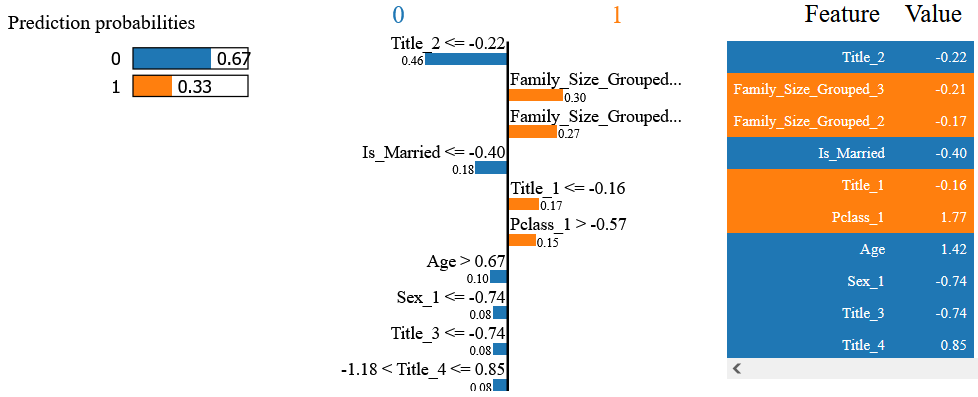

In [38]:
Image(filename='D:/pierr/Documents/images/titanic_lime.png',width=800,height=600)

In [39]:
pickle.dump(model, open('model.pkl', 'wb'))